In [77]:
import pandas as pd

import folium

import geopandas as gp

import numpy as np



from scipy.spatial import ConvexHull

import random

from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt


In [78]:
Zone_data = gp.read_file('./Data/NYC_Zones/geo_export_789b911c-2a6d-4092-a682-6c5e6ce53409.shp')

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data=Zone_data[['Zone_id','borough','zone','geometry']]

Zone_data['center'] = Zone_data.apply(lambda x:x['geometry'].centroid,axis=1)

Zone_data

Zone_id        borough                       zone  \
0      Zone_0            EWR             Newark Airport   
1      Zone_1         Queens                Jamaica Bay   
2      Zone_2          Bronx    Allerton/Pelham Gardens   
3      Zone_3      Manhattan              Alphabet City   
4      Zone_4  Staten Island              Arden Heights   
..        ...            ...                        ...   
258  Zone_258       Brooklyn  Williamsburg (South Side)   
259  Zone_259          Bronx         Woodlawn/Wakefield   
260  Zone_260         Queens                   Woodside   
261  Zone_261      Manhattan         World Trade Center   
262  Zone_262      Manhattan             Yorkville East   

                                              geometry  \
0    POLYGON ((-74.18445 40.69500, -74.18449 40.695...   
1    MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...   
2    POLYGON ((-73.84793 40.87134, -73.84725 40.870...   
3    POLYGON ((-73.97177 40.72582, -73.97179 40.725...   
4    POLYGON ((-74.17422 40.56257, -74.17349 40.562...   
..                                                 ...   
258  POLYGON ((-73.95834 40.71331, -73.95681 40.712...   
259  POLYGON ((-73.85107 40.91037, -73.85207 40.909...   
260  POLYGON ((-73.90175 40.76078, -73.90147 40.759...   
261  POLYGON ((-74.01333 40.70503, -74.01327 40.704...   
262  MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...   

                                           center  
0    POINT (-74.17400027276304 40.69183120640133)  
1    POINT (-73.83129854302213 40.61674529165957)  
2    POINT (-73.84742223236718 40.86447368477527)  
3    POINT (-73.97696825691759 40.72375214158459)  
4    POINT (-74.18848410184935 40.55265928694546)  
..                                            ...  
258  POINT (-73.95990462730536 40.71087993337721)  
259  POINT (-73.85221545370123 40.89793202529452)  
260  POINT (-73.90630644197891 40.74423471780134)  
261  POINT (-74.01302277174901 40.70913894067164)  
262  POINT (-73.94651035601468 40.77593240314977)  

[263 rows x 5 columns]

In [79]:
background = folium.Map([40.769602, -73.973667],tiles='openstreetmap',zoom_start=12)

folium.Choropleth(
    geo_data=Zone_data[['geometry']],
    fill_color='blue',
    fill_opacity=0.4,
    name='Zone'
).add_to(background)


for idx, row in Zone_data.iterrows():

    folium.Circle(
        radius=10,
        location=list(row['center'].coords)[0][::-1],
        popup='The Waterfront',
        color='red',
        fill=True,
    ).add_to(background)

folium.LayerControl().add_to(background)

background.save('background.html')

background

In [80]:
class Polygon_transition(object):
    
    def __init__(self, **kwargs):
        """ Load your trained model and initialize the parameters """
        pass
    
    def Get_PolyCoords(self, Geo_Obj):

        if Geo_Obj.type=='Polygon':

            return list(Geo_Obj.exterior.coords)

        elif Geo_Obj.type=='MultiPolygon':
            
            boundary=list()
            
            for polygon in Geo_Obj:
                
                boundary+=list(polygon.exterior.coords)
                
            return boundary
        
    def Get_intersect(self, polygon1,polygon2):
        
        intersect=list(set(polygon1).intersection(set(polygon2)))
        
        if len(intersect)!=0:
            
            return True
        
        else:
            return False

In [88]:
PT=Polygon_transition()

Zone_list=list()

Zone_Center={}

Zone_Boundary={}

for idx, row in Zone_data.iterrows():
    
    zone_id=row['Zone_id']
    
    center=list(row['center'].coords)[0]
    
    boundary=PT.Get_PolyCoords(row['geometry'])
    
    Zone_list.append(zone_id)
    
    Zone_Center[zone_id]=center
    
    Zone_Boundary[zone_id]=boundary
    
Node_size=len(Zone_list)    



Connect_matrix=np.ones([Node_size,Node_size])*float('inf')

Distance_matrix=np.ones([Node_size,Node_size])*float('inf')


for zone in range(Node_size):
    
    Connect_matrix[zone][zone]=1.0
    
    Distance_matrix[zone][zone]=0.0
    
    p1=Zone_data.iloc[zone]['center']
    
    for next_zone in range(1+zone,Node_size,1):
        
        zone_boundary=Zone_Boundary['Zone_'+str(zone)]
        
        next_zone_boundary=Zone_Boundary['Zone_'+str(next_zone)]
        
        p2=Zone_data.iloc[next_zone]['center']

        if PT.Get_intersect(zone_boundary,next_zone_boundary):
            
            Connect_matrix[zone][next_zone]=1.0
            
            Connect_matrix[next_zone][zone]=1.0
            
            Distance_matrix[zone][next_zone]=round(p1.distance(p2),2)
            
            Distance_matrix[next_zone][next_zone]=round(p1.distance(p2),2)


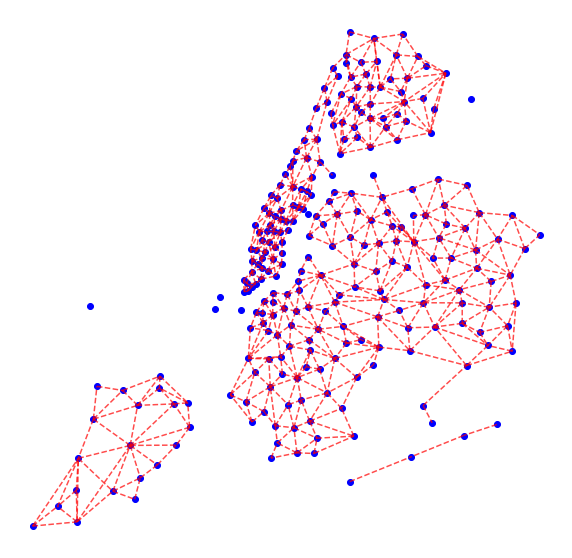

In [91]:
figsize = 10,10

fig,ax = plt.subplots(figsize=figsize)

X=[list(x.coords)[0][0] for x in Zone_data['center']]
Y=[list(x.coords)[0][1] for x in Zone_data['center']]

ax.scatter(X,Y,c='b',alpha=1,linewidths=1)

for zone in range(Node_size):
    zone_id='Zone_'+str(zone)
    in_lng,in_lat=Zone_Center[zone_id][0],Zone_Center[zone_id][1]
    for next_zone in range(1+zone,Node_size,1):
        next_zone_id='Zone_'+str(next_zone)
        out_lng,out_lat=Zone_Center[next_zone_id][0],Zone_Center[next_zone_id][1]
        if Connect_matrix[zone][next_zone]==1.0:
            ax.plot([in_lng,out_lng],[in_lat,out_lat],'r--',alpha=0.7)
    

'''Turn off the axis'''

plt.xticks([])  
plt.yticks([])  
plt.axis('off') 

plt.show()

In [36]:
Dic={}

for idx,row in Zone_data.iterrows():
    zone_id=row['Zone_id']
    geometry=row['geometry']
    Dic[zone_id]=geometry
polys = gp.GeoSeries(Dic)


def Check_point(pnt,polys):
    
    key='None'
    
    for key, geom in polys.items():
        
        if pnt.within(geom):
            
            break
            
    return key

pnts=[Point(-73.975905,40.759796),Point(-73.933160,40.755853),Point(-74.105449,40.576762)]

df=pd.DataFrame(pnts,columns=['points'])

df['Zone_id']=df.apply(lambda x:Check_point(x['points'],polys),axis=1)

df

points   Zone_id
0          POINT (-73.975905 40.759796)  Zone_160
1           POINT (-73.93316 40.755853)  Zone_149
2  POINT (-74.10544899999999 40.576762)  Zone_172